In [101]:
%%HTML
<style> code {background-color : pink !important;} </style>

Load in Vehicle and non Vehicle images
===


In [102]:

import glob
import os

%matplotlib qt
import numpy as np

vehicle_images = 'vehicles/'
images = os.listdir(vehicle_images)

vehicles = []

for image in images:
    vehicles.extend(glob.glob(vehicle_images+image+'/G*/*'))
    vehicles.extend(glob.glob(vehicle_images+image+'/K*/*'))

print("No of vehicles images: ", len(vehicles))

non_vehicle_images = 'non-vehicles/'
images = os.listdir(non_vehicle_images)

non_vehicles = []

for image in images:
    non_vehicles.extend(glob.glob(non_vehicle_images+image+'/GTI*/*'))
    non_vehicles.extend(glob.glob(non_vehicle_images+image+'/E*/*'))

print("No of vehicles images: ", len(non_vehicles))


No of vehicles images:  8792
No of vehicles images:  8968


### Visualize a random Vehicle and non Vehicle image

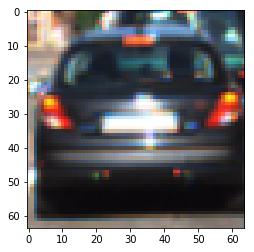

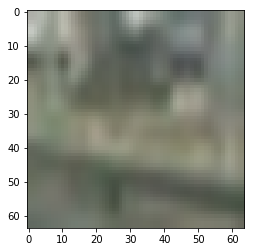

In [103]:
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline

rnd = np.random.randint(0, len(vehicles))
img = mpimg.imread(vehicles[rnd])
plt.imshow(img)
plt.show()

rnd = np.random.randint(0, len(non_vehicles))
img = mpimg.imread(non_vehicles[rnd])
plt.imshow(img)
plt.show()

## Define relevant functions

### Define HOG features

In [104]:
from skimage.feature import hog

def get_hog_features(img, orient, pix_per_cell, cell_per_block, vis, feature_vec):
    
    if vis:
        hog_features, hog_image = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False, visualise=True, feature_vector=feature_vec, block_norm = 'L2-Hys')
        return hog_features, hog_image
    
    else:       
        hog_features = hog(img, orientations=orient,
                          pixels_per_cell=(pix_per_cell, pix_per_cell), 
                          cells_per_block=(cell_per_block, cell_per_block), 
                          transform_sqrt=False, visualise=False, feature_vector=feature_vec, block_norm = 'L2-Hys')                
        return hog_features

    

### Test HOG features function

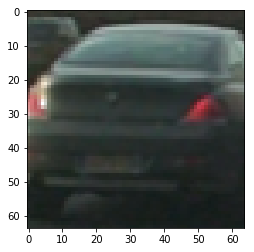

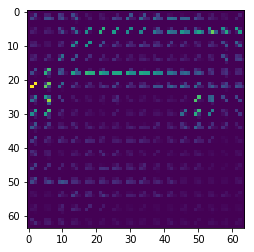

In [105]:
import cv2
# Select a random vehicle image

rnd = np.random.randint(0, len(vehicles))
img = mpimg.imread(vehicles[rnd])
plt.imshow(img)
plt.show()

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
hog_features, hog_img = get_hog_features(img[:,:,0], orient= 20, 
                        pix_per_cell= 4, cell_per_block= 2, 
                        vis=True, feature_vec=True)
plt.imshow(hog_img)
plt.show()


### Define spatial bins and color histograms

In [106]:
# Define a function to compute color histogram features

def color_hist(img, nbins):
    # Compute the histogram of the RGB channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins)

    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))
    return hist_features

def bin_spatial(img, color_space, size):
    # Convert image to new color space (if specified)
    if color_space != 'RGB':
        if color_space == 'HSV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)
        elif color_space == 'LUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2LUV)
        elif color_space == 'HLS':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
        elif color_space == 'YUV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YUV)
        elif color_space == 'YCrCb':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)
        elif color_space == 'HLV':
            feature_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLV)
        else:
            feature_image = np.copy(img) 
    else: feature_image = np.copy(img)  
        
    # Extract each color channel
    color1 = cv2.resize(feature_image[:,:,0], size).ravel()
    color2 = cv2.resize(feature_image[:,:,1], size).ravel()
    color3 = cv2.resize(feature_image[:,:,2], size).ravel()
     # Use cv2.resize().ravel() to create the feature vector
    features = np.hstack((color1, color2, color3))
    # Return the feature vector
    return features

### Test on random image

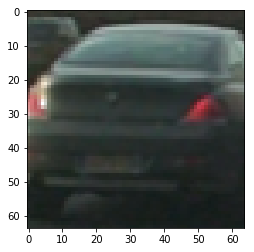

[265 531 661 503 566 277 162 132 130 155  89 119  70  75  79  81  50  19
  42  28  10   5  14   8   7   6   5   2   1   1   1   2 577 494 545 600
 466 233 107  58  85 103 108  81 108  83  76  73  91  71  46  30  27  21
   2   3   3   1   1   0   1   1   0   1 385 507 650 694 400 272 112  82
  79  82 119  85  97  87  87  78 101  69  34  27  29  13   1   2   1   0
   1   0   1   0   0   1]
96
[ 0.21666667  0.21666667  0.22647059 ...,  0.10686275  0.10784314
  0.11568628]
3072


In [107]:

hist_features = color_hist(img, nbins = 32)
plt.imshow(img)
plt.show()
print(hist_features)
print(len(hist_features))

spatial_features = bin_spatial(img, color_space = 'RGB', size=(32,32))
print(spatial_features)
print(len(spatial_features))

### Define a function that applies above functions to the dataset

In [108]:
# The function below takes ina list of images and extract feature vectrs from each and returns the feature vector

def extract_features(imgs, orient, pix_per_cell, cell_per_block, vis, feature_vec, hog_channel,
                   nbins, color_space, size, spatial_feat, hist_feat, hog_feat):
    
    # Create a feature vector
    features = []
    
    # Iterate through all the images
    for img in imgs:
        img_features = []
        
        # read in the image
        image = mpimg.imread(img)
        
        if spatial_feat:
            # extract spatial features
            spatial_features = bin_spatial(image, color_space, size)
            # append to image features vector
            img_features.append(spatial_features)
        
        if hist_feat:
            # extract color histograms
            hist_features = color_hist(image, nbins)
            # append to image features vector
            img_features.append(hist_features)
        
        if hog_feat:
            # Extract hog features
            if hog_channel == 'ALL':
                hog_features = []
                for channel in range(image.shape[2]):
                    hog_features.append(get_hog_features(image[:,:,channel], orient, 
                            pix_per_cell, cell_per_block, 
                            vis, feature_vec))
                hog_features = np.ravel(hog_features)

            elif hog_channel == 'GRAY':
                gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
                hog_features  = get_hog_features(gray, orient, 
                            pix_per_cell, cell_per_block, 
                            vis, feature_vec)
            else:
                hog_features = get_hog_features(image[:,:,hog_channel], orient, 
                            pix_per_cell, cell_per_block, 
                            vis, feature_vec)
            
            # append to image features
            img_features.append(hog_features)
    
        # append the image feature vector to the global feature vector
        features.append(np.concatenate(img_features))
    
    # return the feature vector of all images
    return features


def single_image_features(image, orient, pix_per_cell, cell_per_block, vis, feature_vec, hog_channel,
                   nbins, color_space, size, spatial_feat, hist_feat, hog_feat):
    
    # Create a feature vector    
    img_features = []
    
    # read in the image
    #image = mpimg.imread(img)

    if spatial_feat:
        # extract spatial features
        spatial_features = bin_spatial(image, color_space, size)
        # append to image features vector
        img_features.append(spatial_features)

    if hist_feat:
        # extract color histograms
        hist_features = color_hist(image, nbins)
        # append to image features vector
        img_features.append(hist_features)

    if hog_feat:
        # Extract hog features
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(image.shape[2]):
                hog_features.append(get_hog_features(image[:,:,channel], orient, 
                        pix_per_cell, cell_per_block, 
                        vis, feature_vec))
            hog_features = np.ravel(hog_features)

        elif hog_channel == 'GRAY':
            gray = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
            hog_features  = get_hog_features(gray, orient, 
                        pix_per_cell, cell_per_block, 
                        vis, feature_vec)
        else:
            hog_features = get_hog_features(image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, 
                        vis, feature_vec)

        # append to image features
        img_features.append(hog_features)
    
        if vis:
            return np.concatenate(img_features), hog_image
        else:
            return np.concatenate(img_features)

### Define a sliding window

In [109]:
# The routine below takes in a region of interest and returns bouding boxes

def slide_window(img, x_start_stop=[None, None], y_start_stop=[None, None], 
                    xy_window=(64, 64), xy_overlap=(0.5, 0.5)):
    # If x and/or y start/stop positions not defined, set to image size
    if x_start_stop[0] == None:
        x_start_stop[0] = 0
    if x_start_stop[1] == None:
        x_start_stop[1] = img.shape[1]
    if y_start_stop[0] == None:
        y_start_stop[0] = 0
    if y_start_stop[1] == None:
        y_start_stop[1] = img.shape[0]
    # Compute the span of the region to be searched    
    xspan = x_start_stop[1] - x_start_stop[0]
    yspan = y_start_stop[1] - y_start_stop[0]
    # Compute the number of pixels per step in x/y
    nx_pix_per_step = np.int(xy_window[0]*(1 - xy_overlap[0]))
    ny_pix_per_step = np.int(xy_window[1]*(1 - xy_overlap[1]))
    # Compute the number of windows in x/y
    nx_buffer = np.int(xy_window[0]*(xy_overlap[0]))
    ny_buffer = np.int(xy_window[1]*(xy_overlap[1]))
    nx_windows = np.int((xspan-nx_buffer)/nx_pix_per_step) 
    ny_windows = np.int((yspan-ny_buffer)/ny_pix_per_step) 
    # Initialize a list to append window positions to
    window_list = []
    # Loop through finding x and y window positions
    # Note: you could vectorize this step, but in practice
    # you'll be considering windows one by one with your
    # classifier, so looping makes sense
    for ys in range(ny_windows):
        for xs in range(nx_windows):
            # Calculate window position
            startx = xs*nx_pix_per_step + x_start_stop[0]
            endx = startx + xy_window[0]
            starty = ys*ny_pix_per_step + y_start_stop[0]
            endy = starty + xy_window[1]
            # Append window position to list
            window_list.append(((startx, starty), (endx, endy)))
    # Return the list of windows
    return window_list

### Define search windows

In [122]:
def search_windows(img, windows, clf, scaler, color_space, spatial_size, bins, orient, pix_per_cell,
                  cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat):
    
    # define empty list to fill positive detection windows
    on_windows = []
    
    for window in windows:
        
        # resize image to 64 by 64 as all test images are that size
        test_img = cv2.resize(img[window[0][1]:window[1][1], window[0][0]:window[1][0]], (64, 64))
        
        # extract features
        features = single_image_features(test_img, orient, pix_per_cell, cell_per_block, vis, feature_vec, hog_channel,
                   nbins, color_space, size, spatial_feat, hist_feat, hog_feat)
        
        # normalize data using scaler
        test_features = scaler.transform(np.array(features).reshape(1, -1))
        
        # predict using the classifier
        prediction = clf.predict(test_features)
        
        if prediction == 1:
            on_windows.append(window)
        
    return on_windows

### Define a function for drawing bounding boxes

In [111]:
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    draw_img = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(draw_img, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return draw_img

### Run classifier on vehicle and non vehicle images

In [149]:
# Set the parameters to tune the classifier
import time
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split


orient = 10
pix_per_cell = 8
cell_per_block = 2
vis = False
feature_vec = True 
hog_channel = 'ALL'# could be ALL, 0, 1 , 2
nbins = 32 # no of bins for histogram
color_space = ['RGB'] # could be RGB, HUV, HLV, YCrCb, YUV, HSV
size = (16, 16) # spatial binning dimension
spatial_feat = True # to turn spatial features on and off
hist_feat = True # to turn histogram features on and off
hog_feat = True # to turn HOG features on and off

for cspace in color_space:
    t = time.time()
    #n_samples = 1000
    #rand = np.random.randint(0, len(vehicles), n_samples)

    test_vehicles = vehicles #np.array(vehicles)
    test_non_vehicles = non_vehicles #np.array(non_vehicles)

    print("\nExtracting features ...")

    vehicle_features = extract_features(test_vehicles, orient, pix_per_cell, cell_per_block, vis, feature_vec,
                                       hog_channel, nbins, cspace, size, spatial_feat, hist_feat, hog_feat)

    non_vehicle_features = extract_features(test_non_vehicles, orient, pix_per_cell, cell_per_block, vis, feature_vec,
                                       hog_channel, nbins, cspace, size, spatial_feat, hist_feat, hog_feat)

    print(int(time.time()-t+1), "Seconds to complete feature extraction")

    X = np.vstack((vehicle_features, non_vehicle_features)).astype(np.float64)

    # fit a per column scaler
    X_scaler = StandardScaler().fit(X)

    # apply transform to X
    scaled_X = X_scaler.transform(X)

    y = np.hstack((np.ones(len(vehicle_features)), np.zeros(len(non_vehicle_features))))

    rand_state = np.random.randint(0, 100)
    X_train, X_test, y_train, y_test = train_test_split(scaled_X, y, test_size=0.1, random_state = rand_state)

    print("Feature vector length: ", len(X_train[0]))

    svc = LinearSVC()
    t = time.time()

    print("Training using SVC...")
    svc.fit(X_train, y_train)

    print(int(time.time()-t), "seconds to train ")
    print("Test accuracy of SVC with ", cspace ,": ", svc.score(X_test, y_test))


Extracting features ...
111 Seconds to complete feature extraction
Feature vector length:  6744
Training using SVC...
20 seconds to train 
Test accuracy of SVC with  RGB :  0.971846846847


### Try classifier on test images

test4.jpeg
2.092621088027954 seconds to process the image


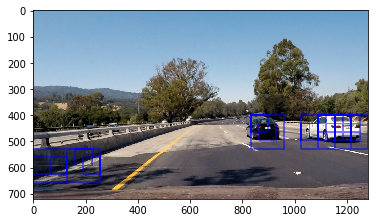

test2.jpeg
2.1782305240631104 seconds to process the image


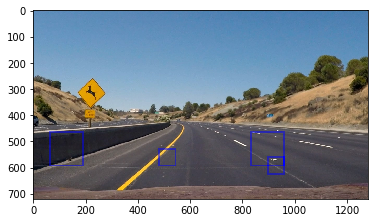

test5.jpeg
2.095430612564087 seconds to process the image


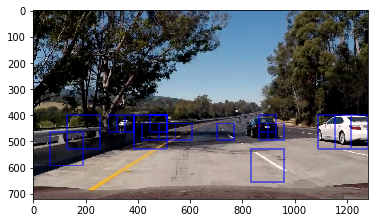

test6.jpeg
2.057114601135254 seconds to process the image


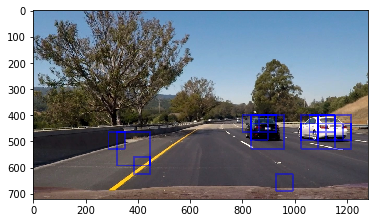

test1.jpeg
2.0668444633483887 seconds to process the image


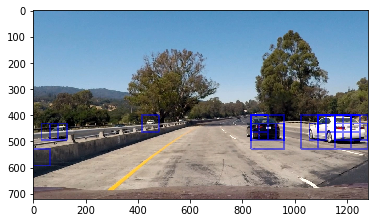

test3.jpeg
2.0791635513305664 seconds to process the image


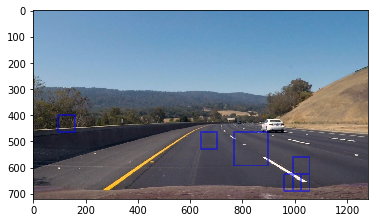

In [161]:
test_images_path = 'test_images/'
test_images = os.listdir(test_images_path)

images = []
titles = []

y_start_stop = [400, 700]
xy_window1 = (128, 128)
xy_window2 = (64, 64)

overlap = 0.5

for image in test_images:

    t = time.time()
    img = mpimg.imread(test_images_path+image)
    draw_img = np.copy(img)
    img = img.astype(np.float32)/255
    
    # define different sized windows
    
    window1 = slide_window(img, x_start_stop = [None, None], y_start_stop = y_start_stop, 
                    xy_window=xy_window1, xy_overlap=(overlap, overlap))
    
    window2 = slide_window(img, x_start_stop = [None, None], y_start_stop = y_start_stop, 
                    xy_window=xy_window2, xy_overlap=(overlap, overlap))
    
    hot_windows1 = search_windows(img, window1, svc, X_scaler, color_space, size, nbins, orient, pix_per_cell,
                  cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
    
    hot_windows2 = search_windows(img, window2, svc, X_scaler, color_space, size, nbins, orient, pix_per_cell,
                  cell_per_block, hog_channel, spatial_feat, hist_feat, hog_feat)
    
    print(image)
    
    window_img1 = draw_boxes(draw_img, hot_windows1, color=(0, 0, 255), thick = 6)
    window_img2 = draw_boxes(draw_img, hot_windows2, color=(0, 0, 255), thick = 6)
    
    window_img = cv2.addWeighted(window_img1, 0.5, window_img2, 0.5, 0)
                            
    images.append(window_img)
    print(time.time() - t, "seconds to process the image")
    
    plt.imshow(window_img)
    plt.show()